# DBSCAN: Density-Based Spatial Clustering of Applications with Noise



In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

## 1. Introduzione al Clustering Basato sulla Densità
Il clustering basato sulla densità è un approccio fondamentalmente diverso rispetto agli algoritmi basati su centroidi come K-means:

- Identifica regioni con alta densità di punti separati da regioni a bassa densità
- Non richiede di specificare il numero di cluster a priori
- Può trovare cluster di forma arbitraria (non solo sferici)
- Può identificare punti di rumore (outlier)


## 2. DBSCAN

### Concetti fondamentali:

1. **Epsilon (ε)**: Il raggio del vicinato intorno a un punto
2. **MinPts**: Numero minimo di punti richiesti in un ε-vicinato per definire un punto come "core"
3. **Punti Core**: Punti che hanno almeno MinPts punti (incluso se stesso) nel loro ε-vicinato
4. **Punti di Bordo o frontiera**: Punti che non sono core ma sono nel vicinato di un punto core
5. **Punti di Rumore**: Punti che non sono né core né bordo

### Come funziona DBSCAN:

1. Per ogni punto, esaminare il vicinato di raggio ε
2. Se contiene almeno MinPts punti, etichettare il punto come core
3. Trovare componenti connesse di punti core, formando i cluster
4. Assegnare ogni punto di bordo al cluster del suo punto core più vicino
5. I punti di rumore rimangono non assegnati o vengono etichettati come outlier


#### Passo 1: Setup e creazione del dataset

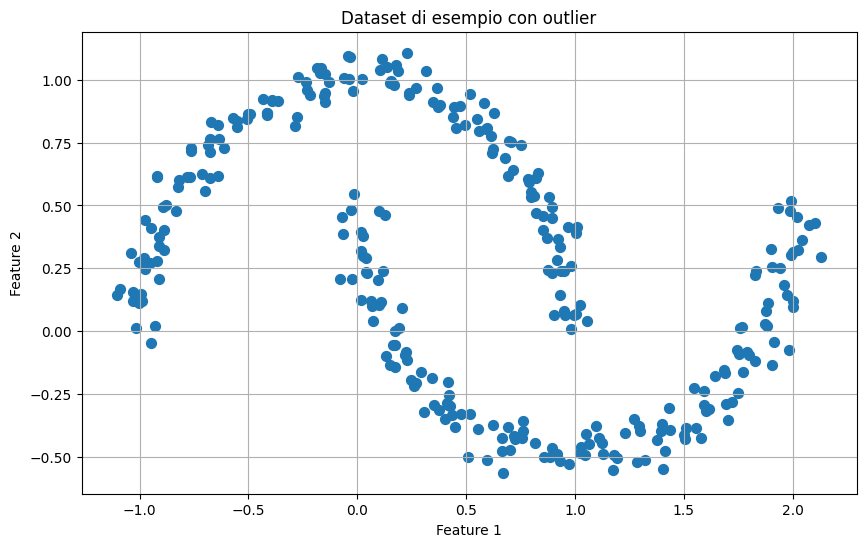

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Creiamo un dataset di esempio con due lune
np.random.seed(42)
X, y_true = make_moons(n_samples=300, noise=0.05, random_state=42)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title('Dataset di esempio con outlier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

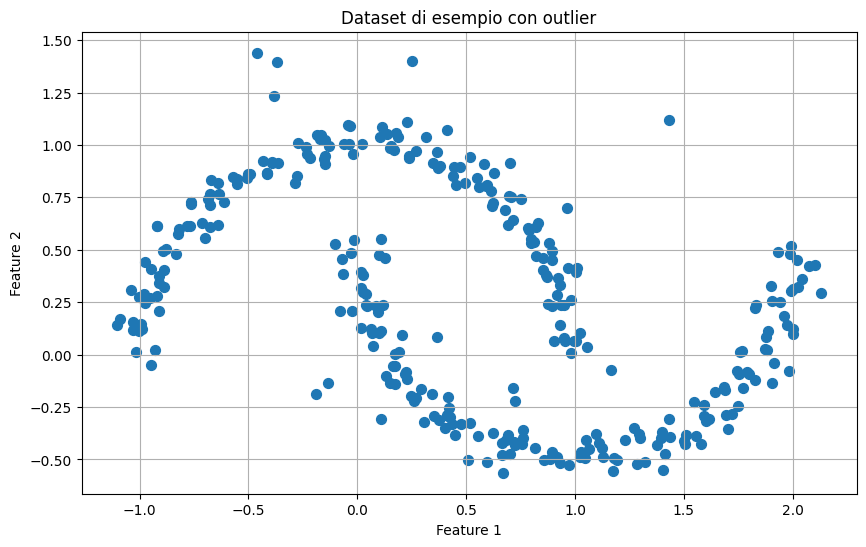

In [26]:
# Aggiungiamo alcuni outlier
outliers = np.random.uniform(low=-0.5, high=1.5, size=(20, 2))
X = np.vstack([X, outliers])
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title('Dataset di esempio con outlier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

In [27]:
X.shape

(320, 2)

#### Passo 2: Visualizzazione del concetto di epsilon-vicinato

In [28]:
# Scegliamo un punto casuale
sample_idx = 150
sample_point = X[sample_idx]

# Definiamo un valore di epsilon
epsilon = 0.2

# Calcoliamo le distanze da questo punto a tutti gli altri
distances = np.sqrt(np.sum((X - sample_point)**2, axis=1))

In [29]:
print("# Distances",len(distances))
distances

# Distances 320


array([1.20723469, 0.11529098, 1.94587455, 0.92459086, 0.73368585,
       0.85540578, 1.39849769, 2.54662707, 0.86651803, 1.62872605,
       0.57939826, 1.73274778, 0.96522394, 1.51389396, 1.62647223,
       0.93272443, 0.4428379 , 1.12408386, 2.72752251, 1.71350961,
       2.16015441, 2.6753543 , 0.43432228, 0.4095068 , 2.63654326,
       1.47121351, 0.22395378, 0.58557899, 1.80004886, 0.48231564,
       0.92962069, 1.78300508, 1.20391148, 1.06648084, 1.07829521,
       2.70445029, 0.80817126, 2.34681689, 1.57262176, 2.18191133,
       2.41094937, 2.19004667, 0.32154368, 1.87675965, 2.20366185,
       1.86231122, 0.7303773 , 0.75517152, 2.61715881, 0.77785379,
       1.57138301, 2.89844473, 0.58518822, 2.08529807, 0.5901212 ,
       0.19374813, 2.40923439, 2.41010966, 1.38666583, 1.10832482,
       0.75701784, 1.76314764, 0.90853286, 1.57063171, 1.60770582,
       1.22850441, 1.07668028, 0.25349177, 1.77983871, 1.54133477,
       2.5197464 , 2.82311051, 0.77272597, 1.38438692, 2.79015

In [30]:

# Troviamo i punti nel vicinato
neighborhood = X[distances <= epsilon]
neighborhood

array([[ 1.90426932, -0.13630295],
       [ 1.87924465,  0.08193158],
       [ 1.76862769,  0.01508363],
       [ 1.77090973, -0.1613516 ],
       [ 1.64239469, -0.17659513],
       [ 1.87199832,  0.02881349],
       [ 1.78996182, -0.08461672],
       [ 1.79718592, -0.09358111],
       [ 1.75772089,  0.01362819],
       [ 1.75377611, -0.09065879],
       [ 1.6893439 , -0.16788857],
       [ 1.82551214, -0.11988554],
       [ 1.88387066,  0.0202976 ],
       [ 1.74938691, -0.24733969],
       [ 1.68636812, -0.15451309],
       [ 1.98196169, -0.07650482],
       [ 1.91507948, -0.04211767],
       [ 1.74248838, -0.07695135]])

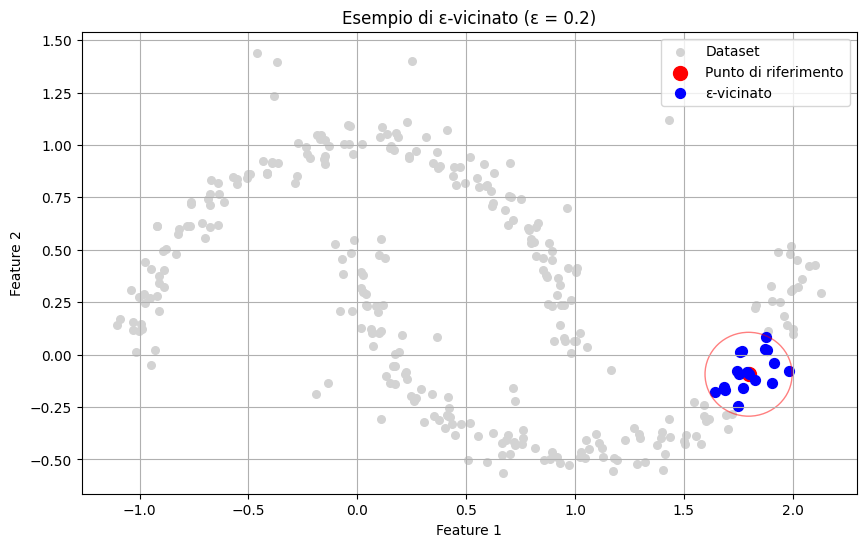

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=30, c='lightgray', label='Dataset')
plt.scatter(sample_point[0], sample_point[1], s=100, c='red', label='Punto di riferimento')
plt.scatter(neighborhood[:, 0], neighborhood[:, 1], s=50, c='blue', label='ε-vicinato')
# Disegniamo il cerchio epsilon
circle = plt.Circle((sample_point[0], sample_point[1]), epsilon, color='r', fill=False, alpha=0.5)
plt.gca().add_patch(circle)

plt.title(f'Esempio di ε-vicinato (ε = {epsilon})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Verifichiamo se questo è un punto core
min_pts = 5
is_core = len(neighborhood) >= min_pts
print(f"Punti nel vicinato: {len(neighborhood)}")
print(f"È un punto core (MinPts = {min_pts})? {is_core}")

Punti nel vicinato: 18
È un punto core (MinPts = 5)? True


#### Passo 3: Scelta dei parametri di DBSCAN

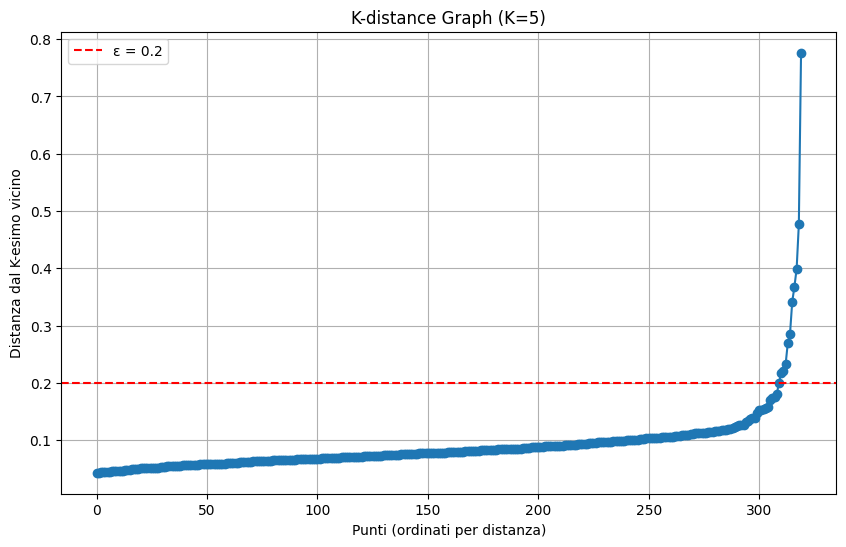

In [33]:
# Utilizziamo il metodo del k-distance graph per trovare un buon valore di epsilon
from sklearn.neighbors import NearestNeighbors

# Consideriamo K=MinPts-1 (escludendo il punto stesso)
k = 5

# Calcoliamo le distanze dai k vicini più prossimi
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)

# Ordiniamo le distanze in ordine crescente
distances = np.sort(distances[:, -1])  # Prendiamo la distanza dal k-esimo vicino

plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances, 'o-')
plt.axhline(y=0.2, color='r', linestyle='--', label='ε = 0.2')
plt.title('K-distance Graph (K=5)')
plt.xlabel('Punti (ordinati per distanza)')
plt.ylabel('Distanza dal K-esimo vicino')
plt.legend()
plt.grid(True)
plt.show()

#### Passo 4: Applicazione di DBSCAN

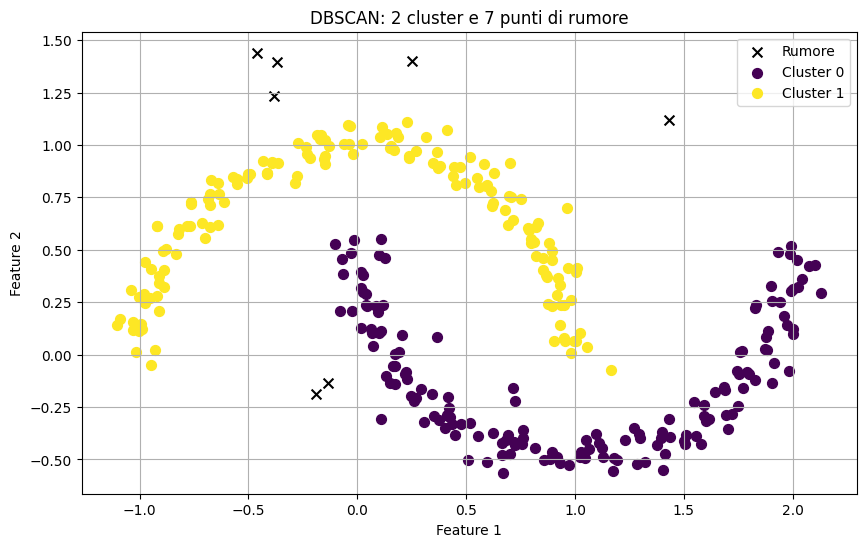

In [34]:
from sklearn.cluster import DBSCAN

# Applichiamo DBSCAN con i parametri scelti
epsilon = 0.2
min_samples = 5

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Contiamo il numero di cluster e punti di rumore
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

# Visualizziamo i risultati
plt.figure(figsize=(10, 6))

# Colori per i diversi cluster
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Plottiamo i punti di rumore
noise_mask = labels == -1
plt.scatter(X[noise_mask, 0], X[noise_mask, 1], s=50, c='black', 
           marker='x', label='Rumore')

# Plottiamo i cluster
for i, color in zip(range(n_clusters), colors):
    cluster_mask = labels == i
    plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=50, c=[color], 
               label=f'Cluster {i}')

plt.title(f'DBSCAN: {n_clusters} cluster e {n_noise} punti di rumore')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

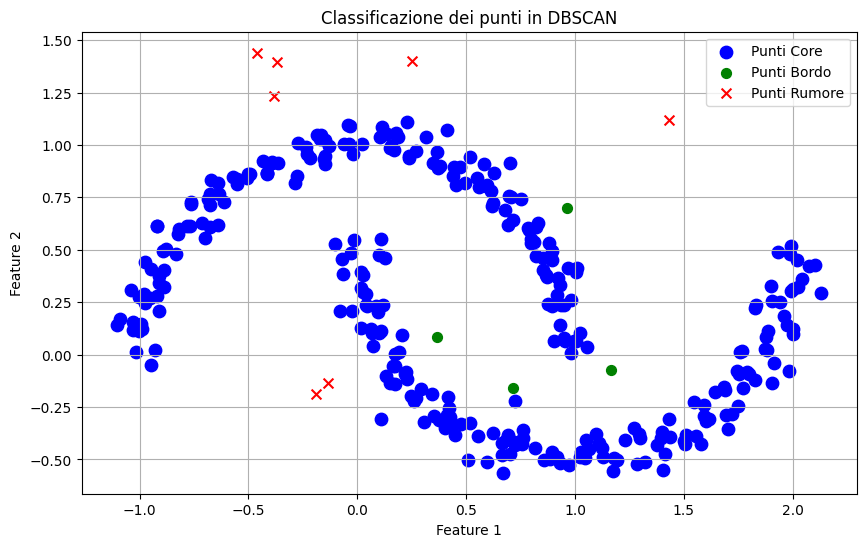

In [35]:
# Identifichiamo automaticamente punti core, bordo e rumore
def identify_point_types(X, labels, eps, min_samples):
    # Inizializziamo vettori per punti core, bordo e rumore
    core_mask = np.zeros_like(labels, dtype=bool)
    border_mask = np.zeros_like(labels, dtype=bool)
    noise_mask = (labels == -1)
    
    # Per ogni punto, controlliamo se è un punto core
    for i in range(len(X)):
        # Se è rumore, non può essere core o bordo
        if noise_mask[i]:
            continue
            
        # Calcoliamo le distanze dai vicini
        distances = np.sqrt(np.sum((X - X[i])**2, axis=1))
        neighbors = np.sum(distances <= eps)
        
        # Se ha abbastanza vicini, è un punto core
        if neighbors >= min_samples:
            core_mask[i] = True
    
    # I punti di bordo sono quelli che non sono né core né rumore
    border_mask = ~core_mask & ~noise_mask
    
    return core_mask, border_mask, noise_mask

# Applichiamo la funzione
core_mask, border_mask, noise_mask = identify_point_types(X, labels, epsilon, min_samples)

# Visualizziamo i tipi di punti
plt.figure(figsize=(10, 6))
plt.scatter(X[core_mask, 0], X[core_mask, 1], s=80, c='blue', marker='o', 
           label='Punti Core')
plt.scatter(X[border_mask, 0], X[border_mask, 1], s=50, c='green', marker='o', 
           label='Punti Bordo')
plt.scatter(X[noise_mask, 0], X[noise_mask, 1], s=50, c='red', marker='x', 
           label='Punti Rumore')

plt.title('Classificazione dei punti in DBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

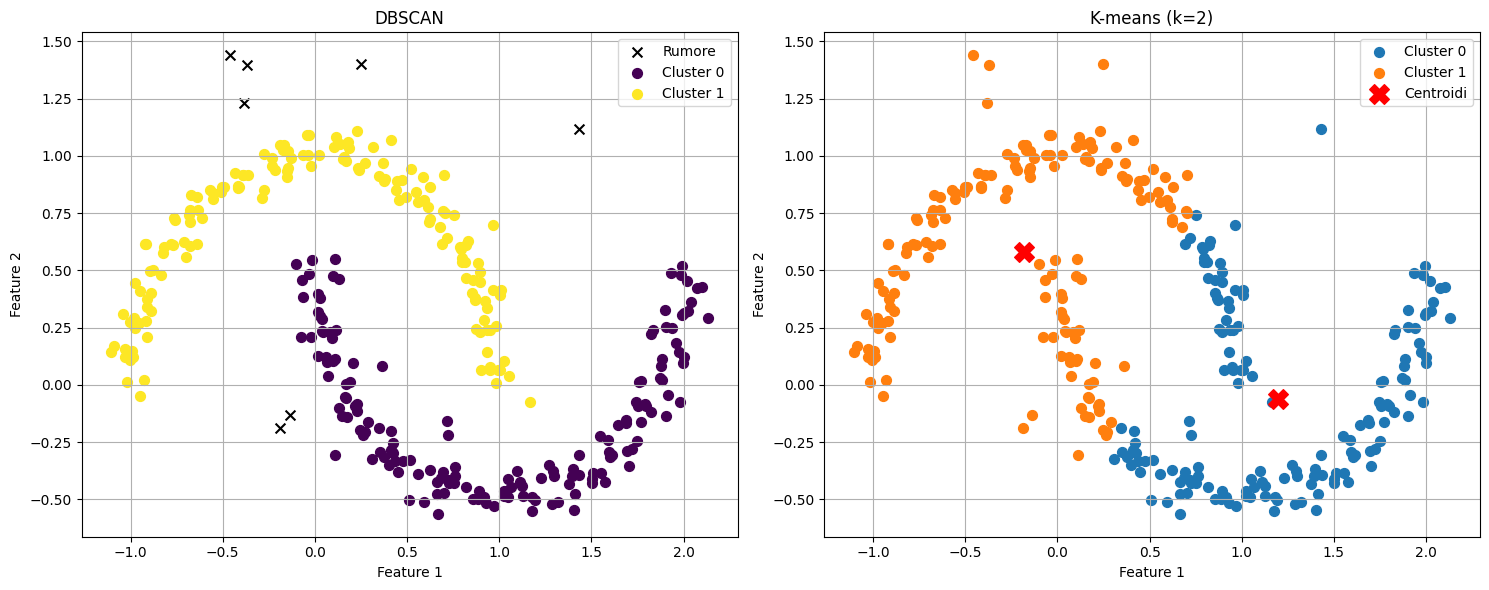

In [36]:
from sklearn.cluster import DBSCAN, KMeans
# Applichiamo K-means allo stesso dataset
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Visualizziamo i risultati di K-means
plt.figure(figsize=(15, 6))

# Subplot per DBSCAN
plt.subplot(1, 2, 1)
plt.scatter(X[noise_mask, 0], X[noise_mask, 1], s=50, c='black', 
           marker='x', label='Rumore')
for i, color in zip(range(n_clusters), colors):
    cluster_mask = labels == i
    plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=50, c=[color], 
               label=f'Cluster {i}')
plt.title('DBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# Subplot per K-means
plt.subplot(1, 2, 2)
for i in range(2):
    cluster_mask = kmeans_labels == i
    plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=50, 
               label=f'Cluster {i}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           s=200, c='red', marker='X', label='Centroidi')
plt.title('K-means (k=2)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Effetto dei Parametri di DBSCAN

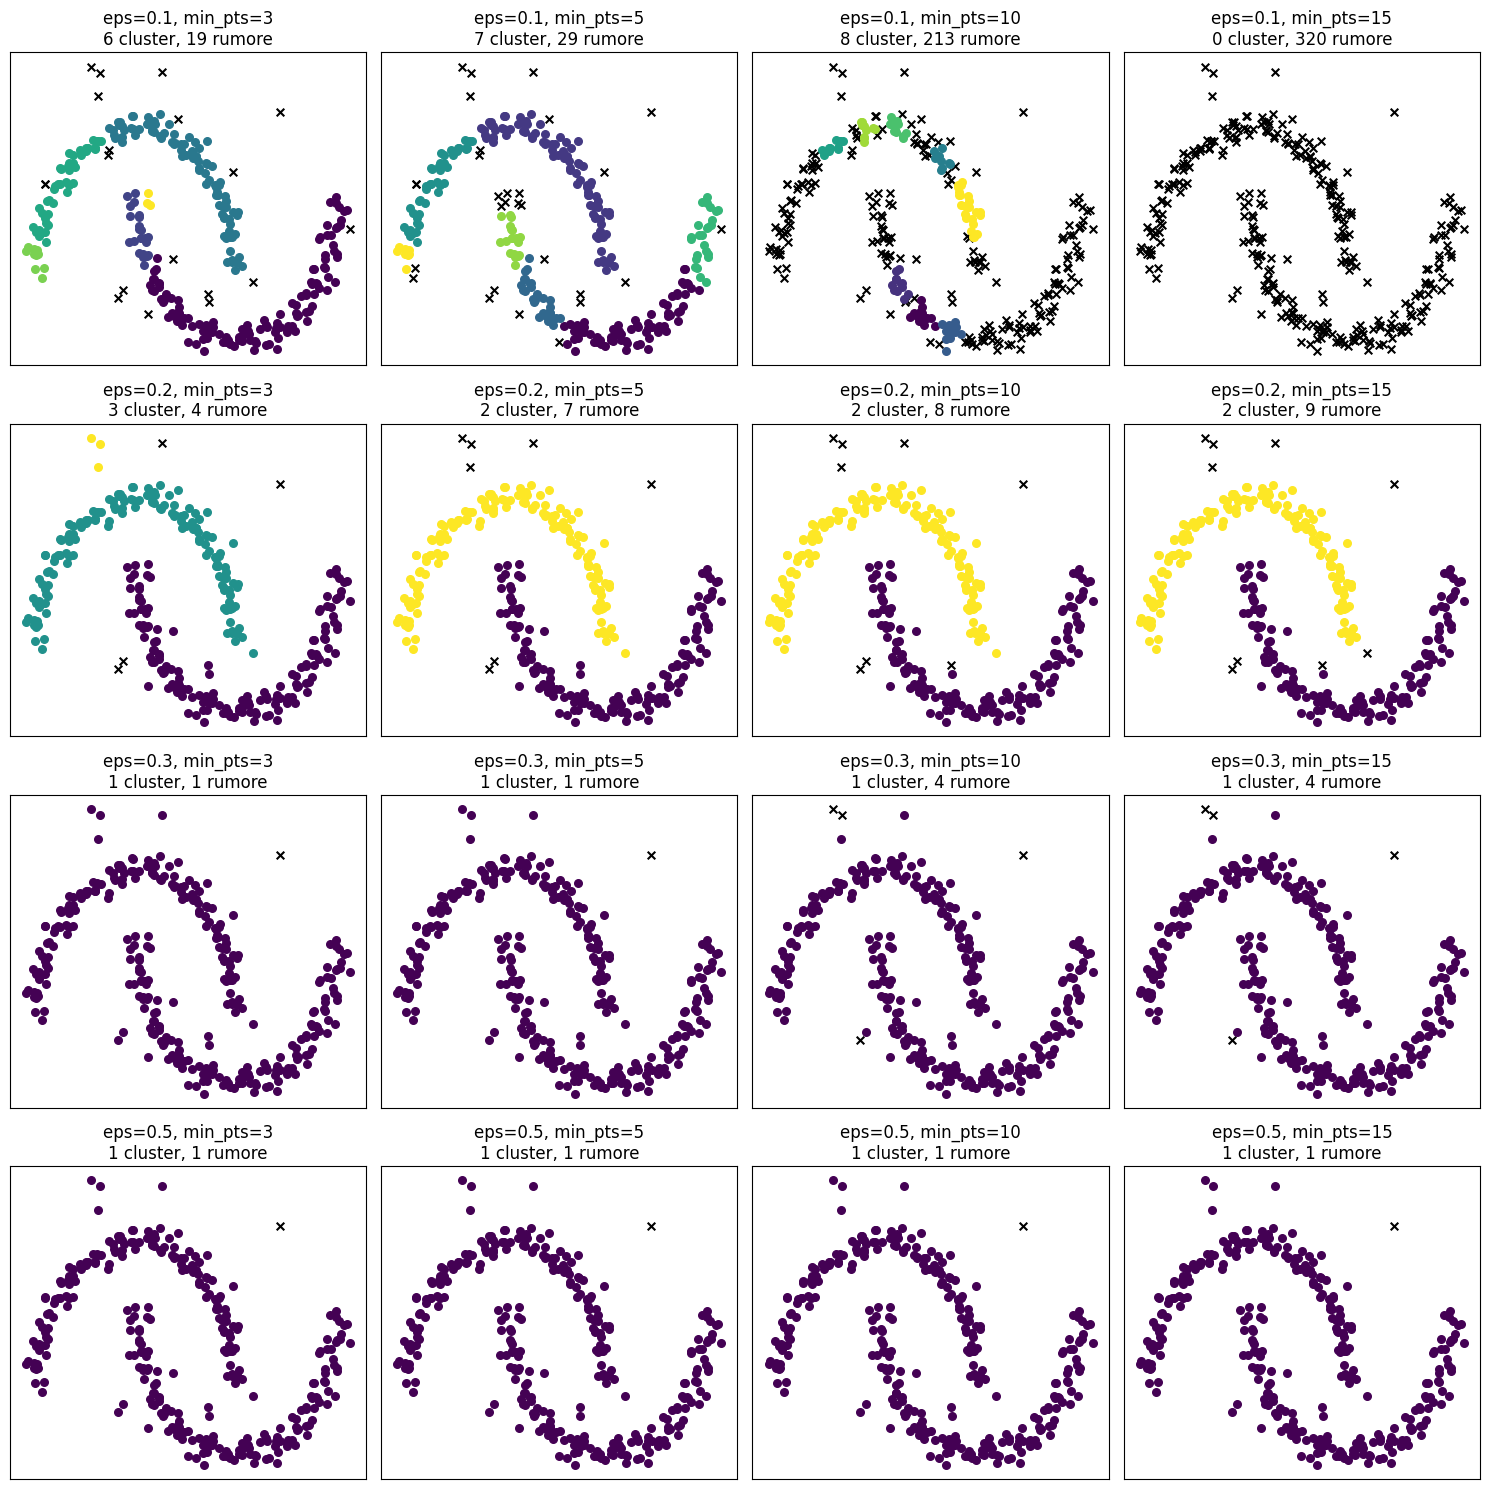

In [37]:
# Studiamo l'effetto di eps e min_samples
epsilons = [0.1, 0.2, 0.3, 0.5]
min_samples_values = [3, 5, 10, 15]

plt.figure(figsize=(15, 15))
plot_idx = 1

for eps in epsilons:
    for min_pts in min_samples_values:
        # Applichiamo DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_pts)
        labels = dbscan.fit_predict(X)
        
        # Contiamo i cluster e i punti di rumore
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Visualizziamo i risultati
        plt.subplot(4, 4, plot_idx)
        plot_idx += 1
        
        # Plottiamo i punti di rumore
        noise_mask = labels == -1
        plt.scatter(X[noise_mask, 0], X[noise_mask, 1], s=30, c='black', 
                   marker='x')
        
        # Plottiamo i cluster
        colors = plt.cm.viridis(np.linspace(0, 1, max(n_clusters, 1)))
        for i, color in zip(range(n_clusters), colors):
            cluster_mask = labels == i
            plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=30, c=[color])
        
        plt.title(f'eps={eps}, min_pts={min_pts}\n{n_clusters} cluster, {n_noise} rumore')
        plt.xticks([])
        plt.yticks([])
        
plt.tight_layout()
plt.show()


## 6. Implementazione di DBSCAN da Zero

In [38]:
class CustomDBSCAN:
    """
    Implementazione personalizzata dell'algoritmo DBSCAN.
    """
    
    def __init__(self, eps=0.5, min_samples=5):
        """
        Inizializza l'algoritmo con i parametri specificati.
        
        Parametri:
        -----------
        eps : float, default=0.5
            Raggio del vicinato.
        min_samples : int, default=5
            Numero minimo di punti in un eps-vicinato per un punto core.
        """
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.core_sample_indices_ = None
    
    def _get_neighbors(self, X, point_idx):
        """
        Trova tutti i punti nel vicinato di raggio eps del punto specificato.
        
        Parametri:
        -----------
        X : array-like, shape (n_samples, n_features)
            Dataset.
        point_idx : int
            Indice del punto nel dataset.
            
        Returns:
        --------
        neighbors : array
            Indici dei punti nel vicinato.
        """
        distances = np.sqrt(np.sum((X - X[point_idx])**2, axis=1))
        return np.where(distances <= self.eps)[0]
    
    def fit(self, X):
        """
        Esegue l'algoritmo DBSCAN sul dataset X.
        
        Parametri:
        -----------
        X : array-like, shape (n_samples, n_features)
            Dataset da clusterizzare.
            
        Returns:
        --------
        self : object
            Istanza aggiornata.
        """
        n_samples = len(X)
        
        # Inizializziamo le etichette (-1 = non visitato)
        self.labels_ = np.full(n_samples, -1)
        
        # Lista dei punti core
        core_samples = []
        
        # Visitiamo ogni punto
        cluster_id = 0
        
        for point_idx in range(n_samples):
            # Se il punto è già stato visitato, continuiamo
            if self.labels_[point_idx] != -1:
                continue
                
            # Troviamo i vicini
            neighbors = self._get_neighbors(X, point_idx)
            
            # Se non ha abbastanza vicini, è rumore
            if len(neighbors) < self.min_samples:
                self.labels_[point_idx] = -1  # Etichettato come rumore
                continue
                
            # Altrimenti, è un punto core e iniziamo un nuovo cluster
            core_samples.append(point_idx)
            self.labels_[point_idx] = cluster_id
            
            # Espandiamo il cluster
            seed_queue = list(neighbors)
            seed_idx = 0
            
            while seed_idx < len(seed_queue):
                current_point = seed_queue[seed_idx]
                
                # Punti etichettati come rumore possono diventare di bordo
                if self.labels_[current_point] == -1:
                    self.labels_[current_point] = cluster_id
                    
                    # Verifichiamo se è un punto core
                    current_neighbors = self._get_neighbors(X, current_point)
                    
                    if len(current_neighbors) >= self.min_samples:
                        core_samples.append(current_point)
                        seed_queue.extend([n for n in current_neighbors if n not in seed_queue])
                        
                seed_idx += 1
                
            # Incrementiamo il cluster ID
            cluster_id += 1
        
        # Salviamo gli indici dei punti core
        self.core_sample_indices_ = np.array(core_samples)
        
        return self
    
    def fit_predict(self, X):
        """
        Esegue fit e restituisce le etichette dei cluster.
        
        Parametri:
        -----------
        X : array-like, shape (n_samples, n_features)
            Dataset da clusterizzare.
            
        Returns:
        --------
        labels : array, shape (n_samples,)
            Etichette dei cluster.
        """
        self.fit(X)
        return self.labels_

#### Testiamo la nostra implementazione

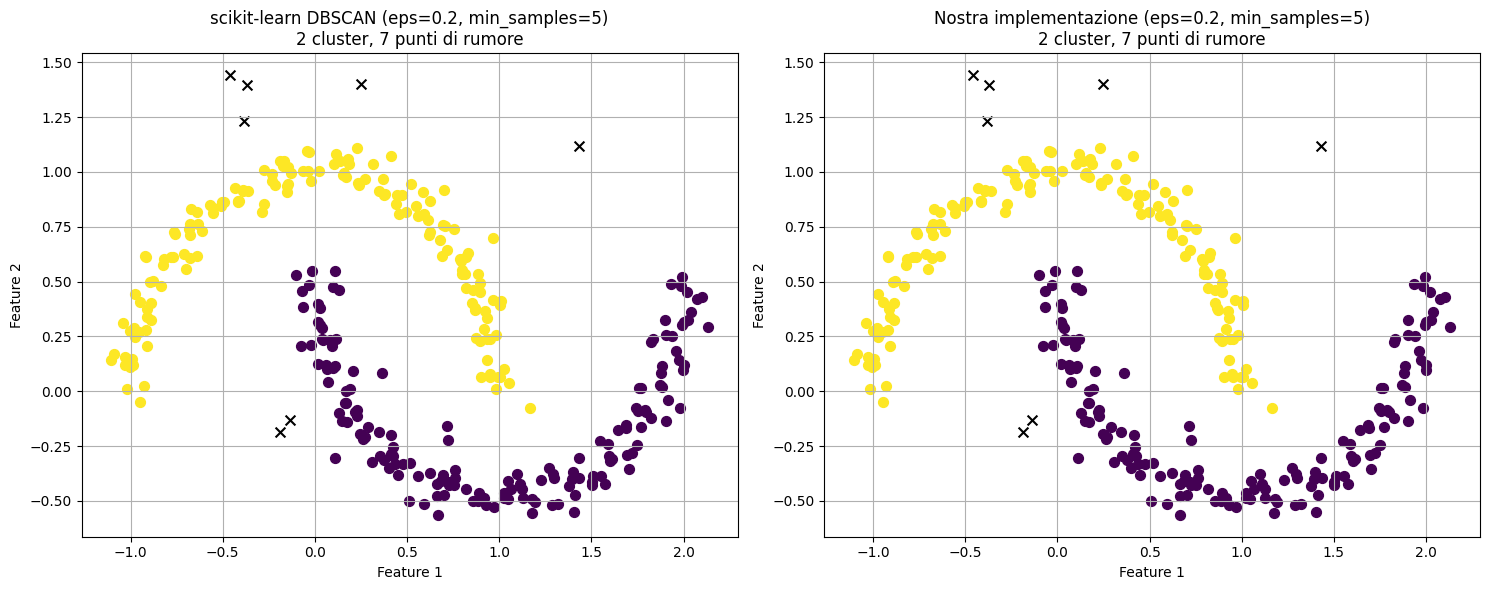

In [39]:
# Applichiamo entrambe le implementazioni di DBSCAN con i parametri ottimali
epsilon = 0.2  
min_samples = 5  

# Implementazione scikit-learn
sklearn_dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
sklearn_labels = sklearn_dbscan.fit_predict(X)

# Nostra implementazione
custom_dbscan = CustomDBSCAN(eps=epsilon, min_samples=min_samples)
custom_labels = custom_dbscan.fit_predict(X)

# Confrontiamo le due implementazioni
plt.figure(figsize=(15, 6))

# Subplot per scikit-learn DBSCAN
plt.subplot(1, 2, 1)
noise_mask_sklearn = sklearn_labels == -1
plt.scatter(X[noise_mask_sklearn, 0], X[noise_mask_sklearn, 1], s=50, c='black', 
           marker='x', label='Rumore')

n_clusters_sklearn = len(set(sklearn_labels)) - (1 if -1 in sklearn_labels else 0)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters_sklearn))

for i, color in zip(range(n_clusters_sklearn), colors):
    cluster_mask = sklearn_labels == i
    plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=50, c=[color], 
               label=f'Cluster {i}')
               
plt.title(f'scikit-learn DBSCAN (eps={epsilon}, min_samples={min_samples})\n'
          f'{n_clusters_sklearn} cluster, {list(sklearn_labels).count(-1)} punti di rumore')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)

# Subplot per la nostra implementazione
plt.subplot(1, 2, 2)
noise_mask_custom = custom_labels == -1
plt.scatter(X[noise_mask_custom, 0], X[noise_mask_custom, 1], s=50, c='black', 
           marker='x', label='Rumore')

n_clusters_custom = len(set(custom_labels)) - (1 if -1 in custom_labels else 0)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters_custom))

for i, color in zip(range(n_clusters_custom), colors):
    cluster_mask = custom_labels == i
    plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=50, c=[color], 
               label=f'Cluster {i}')
               
plt.title(f'Nostra implementazione (eps={epsilon}, min_samples={min_samples})\n'
          f'{n_clusters_custom} cluster, {list(custom_labels).count(-1)} punti di rumore')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. DBSCAN su Diversi Tipi di Dataset

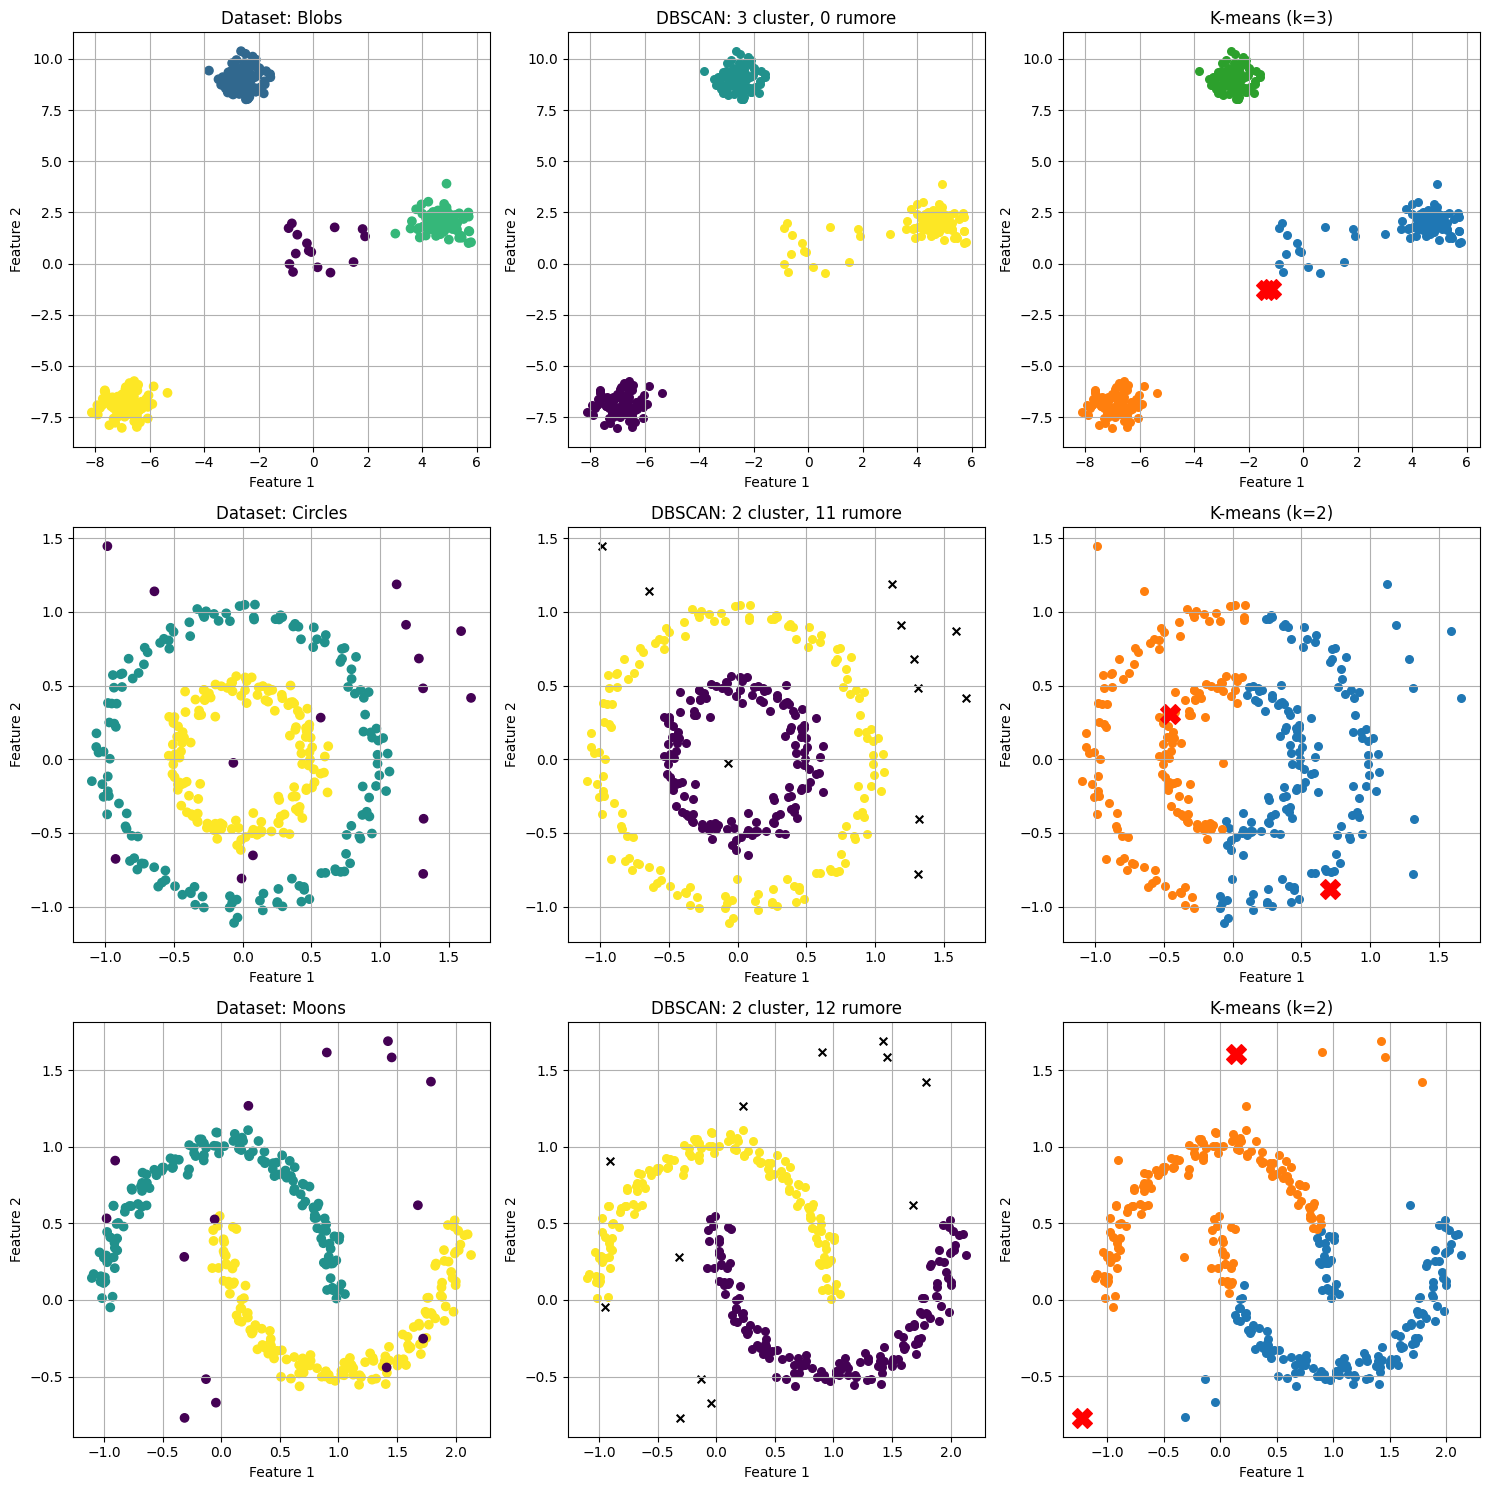

In [40]:
datasets = {
    "Blobs": make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42),
    "Circles": make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42),
    "Moons": make_moons(n_samples=300, noise=0.05, random_state=42)
}

# Aggiungiamo outlier casuali a ciascun dataset
for key in datasets:
    X, y = datasets[key]
    outliers = np.random.uniform(low=-1, high=2, size=(15, 2))
    datasets[key] = (np.vstack([X, outliers]), np.append(y, [-1] * 15))

# Parametri per DBSCAN
dbscan_params = {
    "Blobs": {'eps': 0.3, 'min_samples': 5},
    "Circles": {'eps': 0.3, 'min_samples': 2},
    "Moons": {'eps': 0.2, 'min_samples': 5}
}

# Parametri per K-means 
kmeans_params = {
    "Blobs": {'n_clusters': 3},
    "Circles": {'n_clusters': 2},
    "Moons": {'n_clusters': 2}
}

# Confrontiamo DBSCAN e K-means su ciascun dataset
plt.figure(figsize=(15, 15))
plot_idx = 1

for name, (X, y) in datasets.items():
    # Standardizziamo i dati
    X_scaled = StandardScaler().fit_transform(X)
    
    # Applichiamo DBSCAN
    dbscan = DBSCAN(**dbscan_params[name])
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    # Contiamo i cluster e i punti di rumore
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    # Applichiamo K-means
    kmeans = KMeans(**kmeans_params[name], random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    # Subplot per il dataset originale
    plt.subplot(3, 3, plot_idx)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.title(f'Dataset: {name}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plot_idx += 1
    
    # Subplot per DBSCAN
    plt.subplot(3, 3, plot_idx)
    noise_mask = dbscan_labels == -1
    plt.scatter(X[noise_mask, 0], X[noise_mask, 1], s=30, c='black', 
               marker='x', label='Rumore')
    
    colors = plt.cm.viridis(np.linspace(0, 1, max(n_clusters_dbscan, 1)))
    for i, color in zip(range(n_clusters_dbscan), colors):
        cluster_mask = dbscan_labels == i
        plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=30, c=[color])
    
    plt.title(f'DBSCAN: {n_clusters_dbscan} cluster, {n_noise} rumore')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plot_idx += 1
    
    # Subplot per K-means
    plt.subplot(3, 3, plot_idx)
    for i in range(kmeans_params[name]['n_clusters']):
        cluster_mask = kmeans_labels == i
        plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=30, 
                   label=f'Cluster {i}')
    plt.scatter(X_scaled[None, 0], X_scaled[None, 1], 
               s=200, c='red', marker='X', label='Centroidi')
    plt.title(f'K-means (k={kmeans_params[name]["n_clusters"]})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plot_idx += 1
    
plt.tight_layout()
plt.show()

## 8. Vantaggi e Svantaggi di DBSCAN

### Vantaggi:

- Non richiede di specificare il numero di cluster a priori
- Può trovare cluster di forma arbitraria (non solo sferici)
- Identifica automaticamente outlier come rumore
- Robusto rispetto agli outlier
- Particolarmente adatto per dataset con cluster di densità simile


### Svantaggi:

- Sensibile ai parametri ε e MinPts
- Fatica con cluster di densità molto diverse
- Non gestisce bene dataset ad alta dimensionalità (maledizione della dimensionalità)
- La scelta dei parametri ottimali può essere complessa